In [55]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from collections import Counter
import re
import string
import pickle
import json
import numpy as np


In [56]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/akeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/akeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/akeon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/akeon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
# === LOAD DATA ===
with open("../dataset/dataset_ner_srl.json", "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = [[token.lower() for token in item["tokens"]] for item in data]
ner_labels = [item["labels_ner"] for item in data]
srl_labels = [item["labels_srl"] for item in data]

print(len(sentences), "sentences")

# === COUNTERS ===
ner_counter = Counter()
srl_counter = Counter()

for ner_seq in ner_labels:
    ner_counter.update(ner_seq)

for srl_seq in srl_labels:
    srl_counter.update(srl_seq)

# === PRINT RESULT ===
print("=== NER LABEL COUNTS ===")
for label, count in ner_counter.items():
    print(f"{label} -> {count} labels")

print("\n=== SRL LABEL COUNTS ===")
for label, count in srl_counter.items():
    print(f"{label} -> {count} labels")

78 sentences
=== NER LABEL COUNTS ===
O -> 1003 labels
B-LOC -> 59 labels
V -> 2 labels
B-MISC -> 3 labels
B-TIME -> 3 labels
I-TIME -> 4 labels
I-LOC -> 12 labels
B-QUANT -> 4 labels
I-QUANT -> 5 labels
B-DATE -> 4 labels
B-REL -> 2 labels
B-ETH -> 2 labels
I-ETH -> 2 labels
B-ORG -> 6 labels
I-ORG -> 4 labels
B-MIN -> 6 labels
B-TERM -> 2 labels
I-TERM -> 3 labels
B-RES -> 8 labels
I-RES -> 2 labels

=== SRL LABEL COUNTS ===
ARG1 -> 311 labels
ARGM-LOC -> 65 labels
AM-NEG -> 2 labels
V -> 105 labels
ARGM-SRC -> 13 labels
O -> 194 labels
AM-QUE -> 5 labels
ARGM-BNF -> 6 labels
ARG2 -> 178 labels
ARGM-MNR -> 7 labels
ARG0 -> 68 labels
AM-TMP -> 28 labels
AM-PRP -> 1 labels
AM-MOD -> 5 labels
AM-ADV -> 1 labels
AM-CAU -> 1 labels
AM-EXT -> 6 labels
AM-MNR -> 13 labels
AM-DIS -> 2 labels
AM-FRQ -> 2 labels
ARGM-PNC -> 4 labels
R-ARG1 -> 3 labels
AM-LOC -> 25 labels
AM-DIR -> 4 labels
ARGM-CAU -> 13 labels
ARGM-MOD -> 11 labels
ARGM-EXT -> 2 labels
ARGM-TMP -> 12 labels
ARGM-DIS -> 9 labe

In [58]:
# text preprocessing
stop_words = set(stopwords.words("indonesian"))                                                                                                                                                                                                                                                                             
factory = StemmerFactory()
stemmer = factory.create_stemmer()

with open("../normalize_text/normalize.json", "r", encoding="utf-8") as file:
    normalization_dict = json.load(file)
    
def text_preprocessing(text):
    
    # if(text == "?" or text == "." or text == "!"): return text
    # lowercase
    text = text.lower()
    
    # remove punctuation
    # text = text.translate(str.maketrans("", "", string.punctuation))
    
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # tokenize
    # tokens = word_tokenize(text)
    
    # normalization
    # tokens = normalization_dict.get(text, text)  
  
    
    # stemming
    # tokens = stemmer.stem(tokens)
    
    
    # remove stopwords
    # tokens = [word for word in tokens if word not in stop_words]
    
    # print(f"Original: {text}")
    # print(f"Normalized: {tokens}")
    
    return text

# sentences = [text_preprocessing(" ".join(sentence)) for sentence in sentences]
print("old", sentences)
preprocessing_sentences = []

for text in sentences:
    result = []
    for i in range(len(text)):
        text[i] = text_preprocessing(text[i])
        result.append(text[i])
    preprocessing_sentences.append(result)

print("new", preprocessing_sentences, "\n", len(preprocessing_sentences))

    

old [['keberagaman', 'potensi', 'sumber', 'daya', 'alam', 'indonesia', 'tidak', 'lepas', 'dari', 'proses', 'geografis', 'yang', 'terjadi', '.'], ['bagaimana', 'proses', 'geografis', 'di', 'indonesia', '?'], ['bagaimana', 'pengaruh', 'proses', 'geografis', 'bagi', 'keragaman', 'alam', 'dan', 'keragaman', 'sosial', 'masyarakat', 'indonesia', '?'], ['bagaimana', 'mengoptimalkan', 'peranan', 'sumber', 'daya', 'manusia', 'dalam', 'mengelola', 'sumber', 'daya', 'alam', 'indonesia', '?'], ['apakah', 'sumber', 'daya', 'manusia', 'di', 'indonesia', 'sudah', 'memenuhi', 'syarat', 'untuk', 'mengolah', 'pariwisata', 'yang', 'dimilikinya', '?'], ['bagaimana', 'lembaga', 'sosial', 'yang', 'akan', 'mewadahi', 'untuk', 'mengolah', 'sumber', 'daya', 'alam', 'dan', 'sumber', 'daya', 'manusianya', '?'], ['kalian', 'juga', 'perlu', 'memahami', ',', 'bahwa', 'keragaman', 'sosial', 'dan', 'budaya', 'telah', 'menarik', 'kedatangan', 'bangsa-bangsa', 'asing', 'sejak', 'ribuan', 'tahun', 'yang', 'lalu', '.'], 

In [59]:
words = list(set(word for sentence in preprocessing_sentences for word in sentence))
word2idx = {word: idx + 2 for idx, word in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

all_ner_tags = sorted(set(tag for seq in ner_labels for tag in seq))
all_srl_tags = sorted(set(tag for seq in srl_labels for tag in seq))
tag2idx_ner = {tag: idx for idx, tag in enumerate(all_ner_tags)}
tag2idx_srl = {tag: idx for idx, tag in enumerate(all_srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

print(words)
print(word2idx)
print(all_ner_tags)
print(all_srl_tags)
print(tag2idx_ner)
print(tag2idx_srl)
print(idx2tag_ner)
print(idx2tag_srl)

['baik', 'daratan', 'suatu', 'suhu', 'bumi', 'menemukan', 'memengaruhi', 'sosial', 'letak', 'hidrat', 'perairan', 'geologis', 'puluhan', 'lain', 'kalah', 'penyebab', 'emas', 'tambang', 'hindu-buddha', 'simak', 'pemandangan', 'sesuatu', 'makanan', 'sedikit', 'intelegensi', 'wilayah', 'kitab', 'tertentu', 'varietas', 'atau', 'kemudian', 'kapal', 'mata', 'juta', 'darussalam', 'tanahnya', 'sangat', 'kelima', 'kegiatan', 'liar', 'hilangnya', 'april-september', 'pelayaran', 'pencaharian', 'sih', 'udara', 'merancang', 'pelajari', 'negara-negara', 'lawu', 'keagamaan', 'kualitas', 'iklim', 'asia', 'alat', 'laporan', 'cave', 'upacara', 'urutan', 'kesenangan', 'bahan', 'mengelola', 'mengurangi', 'orang', 'mencakup', 'bersyukur', 'tanah', 'banyak', 'diamati', 'mencerminkan', 'raga', 'rata-rata', 'jatuh', 'kemarau', 'bahwa', 'masyarakat', 'budaya', 'meningkatkan', 'antara', 'peranan', 'memungkinkan', 'maritim', 'apabila', 'apakah', '.', 'tanaman', 'yang', 'ke', 'tenggara', 'cadangan', 'setiap', 'pe

In [60]:

# === ENCODING ===
X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in ts] for ts in ner_labels]
y_srl = [[tag2idx_srl[t] for t in ts] for ts in srl_labels]

maxlen = 50

X = pad_sequences(X, maxlen=maxlen, padding="post", value=word2idx["PAD"])
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=tag2idx_ner["O"])
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=tag2idx_srl["O"])

y_ner_cat = [to_categorical(seq, num_classes=len(tag2idx_ner)) for seq in y_ner]
y_srl_cat = [to_categorical(seq, num_classes=len(tag2idx_srl)) for seq in y_srl]

print(X)
print("y_ner \n ")
print(y_ner)
print("y_srl \n ")
print(y_srl)
print("y_ner cat \n ")
print(y_ner_cat)
print("y_srl cat \n ")
print(y_srl_cat)


[[192 102 269 ...   0   0   0]
 [105 180 350 ...   0   0   0]
 [105 344 180 ...   0   0   0]
 ...
 [ 53 403 380 ...   0   0   0]
 [177 142 328 ...   0   0   0]
 [ 53 269 135 ...   0   0   0]]
y_ner 
 
[[18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 ...
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]]
y_srl 
 
[[15 15 15 ... 33 33 33]
 [12 15 15 ... 33 33 33]
 [12 15 15 ... 33 33 33]
 ...
 [14 14 14 ... 33 33 33]
 [15 15 33 ... 33 33 33]
 [14 14 14 ... 33 33 33]]
y_ner cat 
 
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [61]:
# split dataset 
X_temp, X_test, y_ner_temp, y_ner_test, y_srl_temp, y_srl_test = train_test_split(
    X, y_ner_cat, y_srl_cat, test_size=0.1, random_state=42
)
X_train, X_val, y_ner_train, y_ner_val, y_srl_train, y_srl_val = train_test_split(
    X_temp, y_ner_temp, y_srl_temp, test_size=0.1111, random_state=42  # ~10% of total
)

In [62]:
#training model
input_layer = Input(shape=(maxlen,))
embedding = Embedding(input_dim=len(word2idx), output_dim=64)(input_layer)
bilstm = Bidirectional(LSTM(units=64, return_sequences=True))(embedding)
out_ner = TimeDistributed(Dense(len(tag2idx_ner), activation="softmax"), name="ner_output")(bilstm)
out_srl = TimeDistributed(Dense(len(tag2idx_srl), activation="softmax"), name="srl_output")(bilstm)

model = Model(inputs=input_layer, outputs=[out_ner, out_srl])
model.compile(
    optimizer="adam",
    loss={"ner_output": "categorical_crossentropy", "srl_output": "categorical_crossentropy"},
    metrics={"ner_output": "accuracy", "srl_output": "accuracy"}
)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 50, 64)    │     27,328 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 50, 128)   │     66,048 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 50, 20)    │      2,580 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 50, 36)    │      4,644 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,600 (392.97 KB)

 Trainable params: 100,600 (392.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 4.8129 - ner_output_accuracy: 0.9343 - ner_output_loss: 1.9817 - srl_output_accuracy: 0.6363 - srl_output_loss: 2.8312 - val_loss: 1.0304 - val_ner_output_accuracy: 0.9500 - val_ner_output_loss: 0.3266 - val_srl_output_accuracy: 0.7825 - val_srl_output_loss: 0.7039
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2668 - ner_output_accuracy: 0.9576 - ner_output_loss: 0.3078 - srl_output_accuracy: 0.7510 - srl_output_loss: 0.9590 - val_loss: 0.8654 - val_ner_output_accuracy: 0.9500 - val_ner_output_loss: 0.2764 - val_srl_output_accuracy: 0.8550 - val_srl_output_loss: 0.5891
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0249 - ner_output_accuracy: 0.9636 - ner_output_loss: 0.2245 - srl_output_accuracy: 0.7679 - srl_output_loss: 0.8004 - val_loss: 0.8157 - val_ner_output_accuracy: 0.9500 - val_ner_output_loss: 0.2696 - val_srl_output_accuracy: 0.8600 - val_srl_output_loss: 0.5461
Epoch 4/10
31/31 ━━━━━━━━

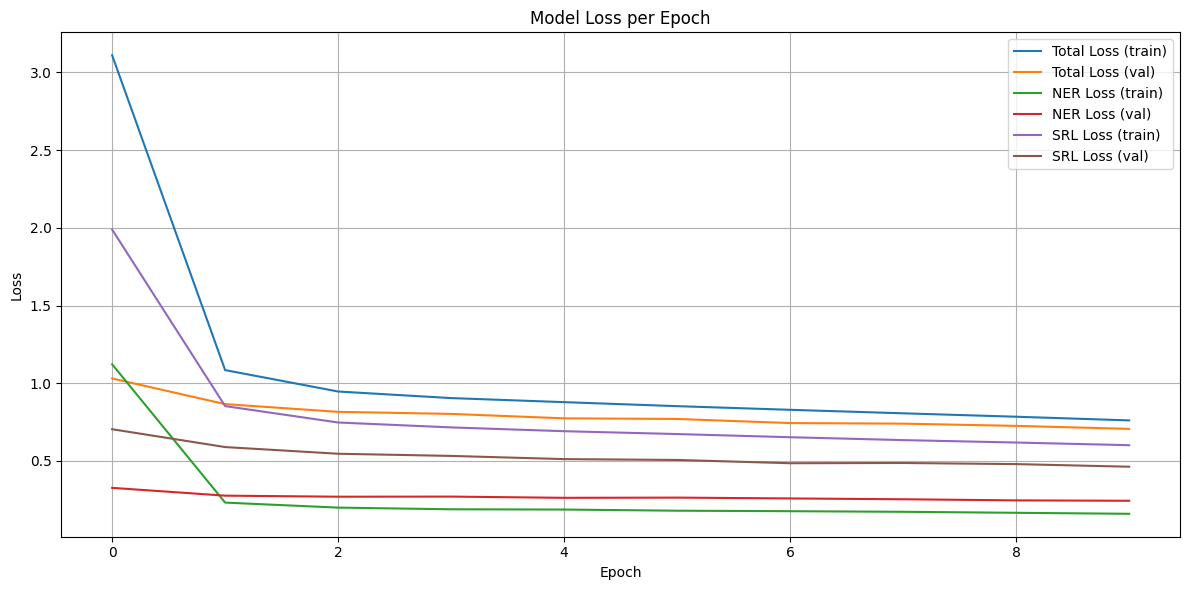

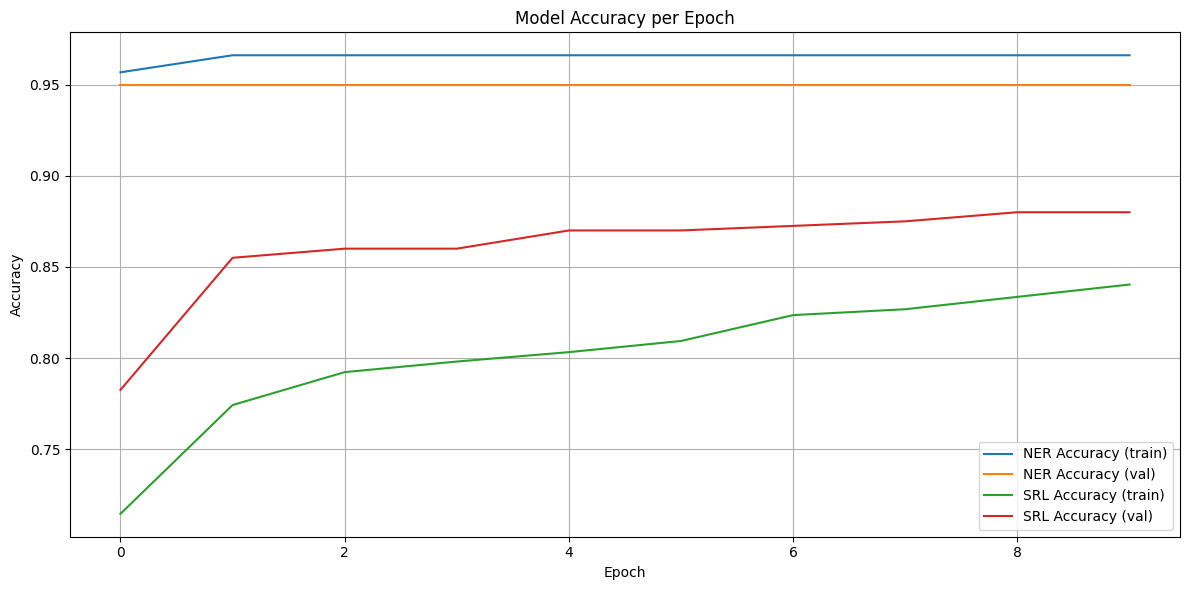

In [63]:

# === TRAINING ===
history = model.fit(
    X_train,
    {"ner_output": np.array(y_ner_train), "srl_output": np.array(y_srl_train)},
    validation_data=(X_val, {"ner_output": np.array(y_ner_val), "srl_output": np.array(y_srl_val)}),
    batch_size=2,
    epochs=10
)

# === SAVE ===
model.save("multi_task_bilstm_model.keras")
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("tag2idx_ner.pkl", "wb") as f:
    pickle.dump(tag2idx_ner, f)
with open("tag2idx_srl.pkl", "wb") as f:
    pickle.dump(tag2idx_srl, f)
    
    
history_dict = history.history

# === LOSS ===
plt.figure(figsize=(12, 6))

plt.plot(history_dict["loss"], label="Total Loss (train)")
plt.plot(history_dict["val_loss"], label="Total Loss (val)")
plt.plot(history_dict["ner_output_loss"], label="NER Loss (train)")
plt.plot(history_dict["val_ner_output_loss"], label="NER Loss (val)")
plt.plot(history_dict["srl_output_loss"], label="SRL Loss (train)")
plt.plot(history_dict["val_srl_output_loss"], label="SRL Loss (val)")

plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === ACCURACY ===
plt.figure(figsize=(12, 6))

plt.plot(history_dict["ner_output_accuracy"], label="NER Accuracy (train)")
plt.plot(history_dict["val_ner_output_accuracy"], label="NER Accuracy (val)")
plt.plot(history_dict["srl_output_accuracy"], label="SRL Accuracy (train)")
plt.plot(history_dict["val_srl_output_accuracy"], label="SRL Accuracy (val)")

plt.title("Model Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
# evaluation
y_pred_ner, y_pred_srl = model.predict(X_test)

y_true_ner = [[idx2tag_ner[np.argmax(tok)] for tok in seq] for seq in y_ner_test]
y_pred_ner = [[idx2tag_ner[np.argmax(tok)] for tok in seq] for seq in y_pred_ner]

y_true_srl = [[idx2tag_srl[np.argmax(tok)] for tok in seq] for seq in y_srl_test]
y_pred_srl = [[idx2tag_srl[np.argmax(tok)] for tok in seq] for seq in y_pred_srl]

print("\n📊 [NER] Test Set Classification Report:")
print(classification_report(y_true_ner, y_pred_ner))

print("\n📊 [SRL] Test Set Classification Report:")
print(classification_report(y_true_srl, y_pred_srl))


# import numpy as np

# # Prediksi model (output = probabilitas)
# y_pred_ner = model.predict(X_test)[0]
# y_pred_ner_idx = np.argmax(y_pred_ner, axis=-1)
# y_true_ner_idx = np.argmax(y_ner_test, axis=-1)

# # Mapping ke string
# y_pred_ner_str = []
# y_true_ner_str = []

# for y_true_seq, y_pred_seq in zip(y_true_ner_idx, y_pred_ner_idx):
#     true_seq = []
#     pred_seq = []
#     for t, p in zip(y_true_seq, y_pred_seq):
#         if idx2tag_ner[t] != "PAD":
#             true_seq.append(idx2tag_ner[t])
#             pred_seq.append(idx2tag_ner[p])
#     y_true_ner_str.append(true_seq)
#     y_pred_ner_str.append(pred_seq)

# from seqeval.metrics import classification_report
# print("\n📊 [NER] Test Set Classification Report:")
# print(classification_report(y_true_ner_str, y_pred_ner_str))


# from collections import Counter

# flat_preds = [tag for seq in y_pred_ner_str for tag in seq]
# print(Counter(flat_preds))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step

📊 [NER] Test Set Classification Report:
              precision    recall  f1-score   support

         LOC       0.00      0.00      0.00         6
       QUANT       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         7
   macro avg       0.00      0.00      0.00         7
weighted avg       0.00      0.00      0.00         7


📊 [SRL] Test Set Classification Report:
              precision    recall  f1-score   support

         BNF       0.00      0.00      0.00         1
         EXT       0.00      0.00      0.00         2
         LOC       0.00      0.00      0.00         4
         MNR       0.00      0.00      0.00         1
         MOD       0.00      0.00      0.00         1
         NEG       0.00      0.00      0.00         1
         PRP       0.00      0.00      0.00         1
         QUE       0.00      0.00      0.00         1
         RG0       0.00      0.00      0.00         5
         RG

/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/se

In [65]:

def plot_confusion_matrix(y_true_flat, y_pred_flat, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

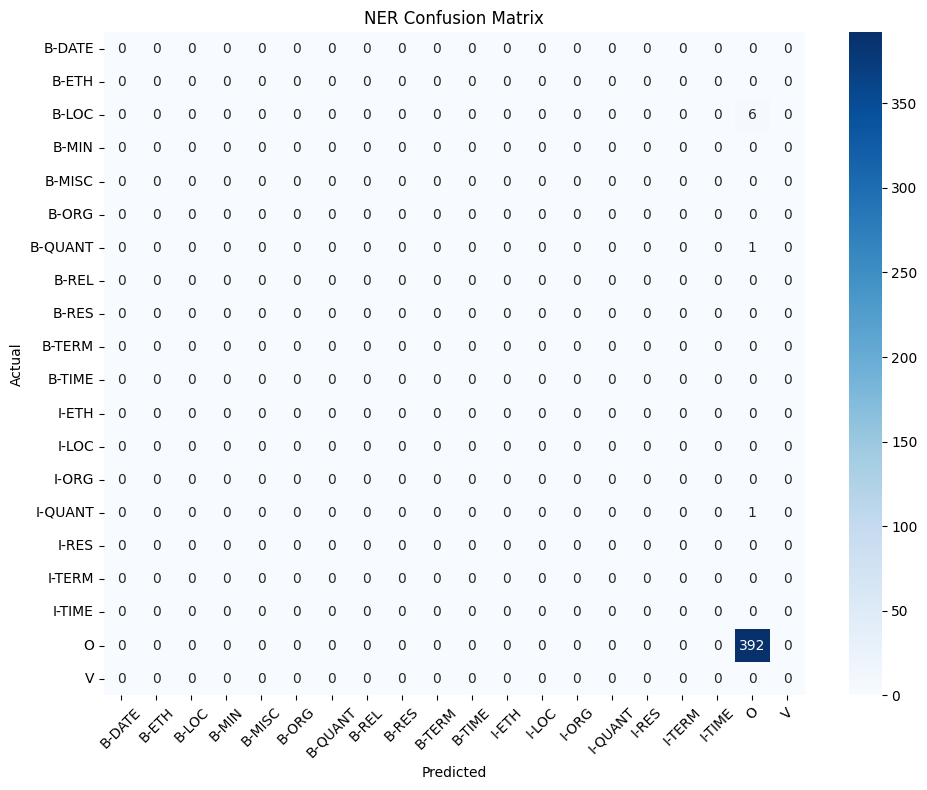

In [66]:

# Flatten label
y_true_flat_ner = [tag for seq in y_true_ner for tag in seq]
y_pred_flat_ner = [tag for seq in y_pred_ner for tag in seq]

# Buat plot
plot_confusion_matrix(
    y_true_flat_ner, 
    y_pred_flat_ner, 
    labels=list(tag2idx_ner.keys()), 
    title="NER Confusion Matrix"
)


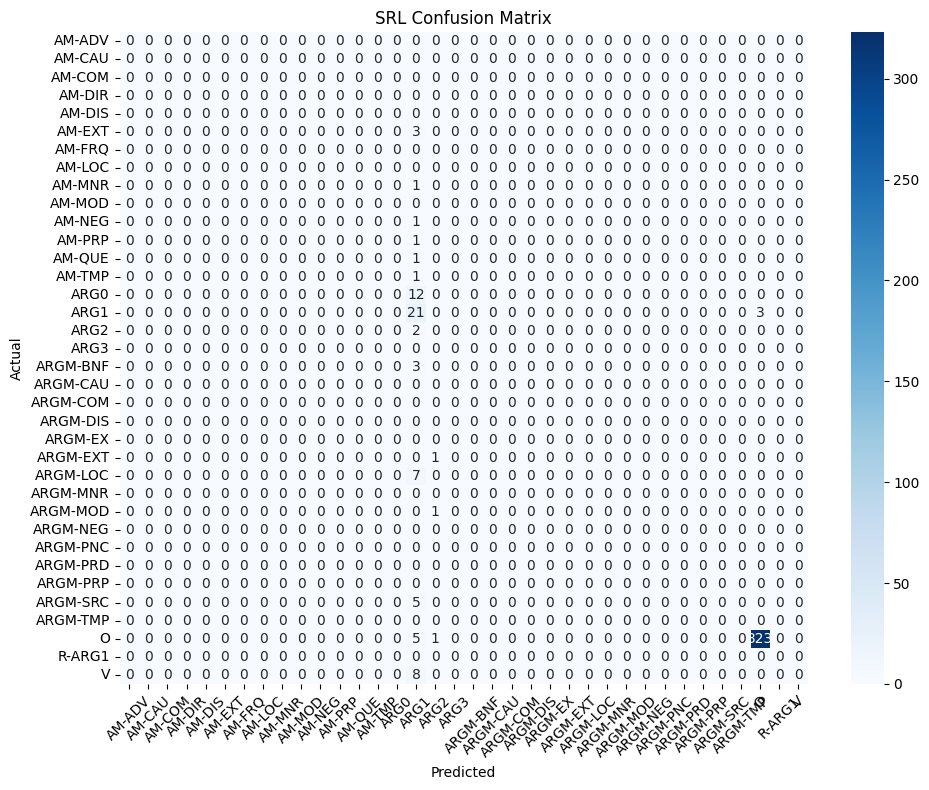

In [67]:
y_true_flat_srl = [tag for seq in y_true_srl for tag in seq]
y_pred_flat_srl = [tag for seq in y_pred_srl for tag in seq]

plot_confusion_matrix(
    y_true_flat_srl, 
    y_pred_flat_srl, 
    labels=list(tag2idx_srl.keys()), 
    title="SRL Confusion Matrix"
)
